In [124]:
import cv2                 # working with, mainly resizing, images
import pandas as pd
import numpy as np         # dealing with arrays
import matplotlib.pyplot as plt
import seaborn as sns
import os                  # dealing with directories
import random                # mixing up or currently ordered data that might lead our network astray in training.
from tqdm import tqdm      # a nice pretty percentage bar for tasks. Thanks to viewer Daniel BA1/4hler for this suggestion

%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans

import xgboost
from sklearn.svm import LinearSVC
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import BaggingClassifier 
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn import metrics

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix

from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt, matplotlib.image as mpimg

In [86]:
DATA_DIR = r'C:\Users\idank\CourseProject\train'
LR = 1e-3

def label_img(img):
    word_label = img.split('.')[-3]
    # conversion to one-hot array [cat,dog]
    #                            [much cat, no dog]
    if word_label == 'cat': return [1,0]
    #                             [no cat, very doggo]
    elif word_label == 'dog': return [0,1]
    
def create_train_data(img_size, file_name):
    data = []
    for img in tqdm(os.listdir(DATA_DIR)):
        label = label_img(img)
        path = os.path.join(DATA_DIR,img)
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (img_size,img_size))
        data.append([np.array(img),np.array(label)])
    random.Random(42).shuffle(data)
    np.save(file_name, data)
    return data
# If you have already created the dataset:
#train_data = np.load('file_name.npy')

### I will make 2 sets of X data, 50*50 images and 100*100 images
#### maybe there will be a different, I will check

In [87]:
data_50 = create_train_data(50, "train_data_50.npy")

100%|███████████████████████████████████████████████████████████████████████████| 25000/25000 [00:53<00:00, 463.30it/s]


In [88]:
data_100 = create_train_data(100, "train_data_100.npy")

100%|███████████████████████████████████████████████████████████████████████████| 25000/25000 [00:39<00:00, 632.18it/s]


In [131]:
X_50_50 = np.array([i[0] for i in data_50]).reshape(25000,2500)
X_100_100 = np.array([i[0] for i in data_100]).reshape(25000,10000)
Y = pd.Series([i[1][0] for i in data_50]) # dog=0. cat=1

# normalaize the data:
X_100_100 = X_100_100/255.
X_50_50 = X_50_50/255.

In [132]:
pd.DataFrame(X_50_50)

,0,1,2,3,4,5,6,7,8,9,...,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
0,0.823529,0.482353,0.490196,0.466667,0.521569,0.517647,0.517647,0.517647,0.560784,0.474510,...,0.270588,0.247059,0.152941,0.192157,0.168627,0.149020,0.184314,0.145098,0.247059,0.552941
1,0.482353,0.501961,0.498039,0.521569,0.513725,0.521569,0.552941,0.521569,0.498039,0.388235,...,0.525490,0.545098,0.576471,0.631373,0.619608,0.607843,0.615686,0.584314,0.572549,0.560784
2,0.635294,0.674510,0.760784,0.839216,0.886275,0.764706,0.729412,0.698039,0.709804,0.541176,...,0.596078,0.564706,0.517647,0.537255,0.466667,0.482353,0.521569,0.509804,0.419608,0.462745
3,0.372549,0.337255,0.345098,0.407843,0.431373,0.337255,0.364706,0.341176,0.333333,0.372549,...,0.850980,0.819608,0.796078,0.796078,0.772549,0.811765,0.768627,0.635294,0.776471,0.749020
4,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,...,0.164706,0.164706,0.168627,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,0.078431,0.070588,0.086275,0.082353,0.082353,0.078431,0.082353,0.082353,0.078431,0.078431,...,0.666667,0.647059,0.709804,0.741176,0.392157,0.760784,0.682353,0.556863,0.619608,0.560784
24996,0.654902,0.650980,0.654902,0.658824,0.666667,0.682353,0.682353,0.647059,0.682353,0.698039,...,0.776471,0.949020,0.360784,0.521569,0.478431,0.588235,0.552941,0.600000,0.564706,0.815686
24997,0.396078,0.486275,0.498039,0.545098,0.517647,0.576471,0.466667,0.572549,0.615686,0.458824,...,0.576471,0.525490,0.647059,0.501961,0.662745,0.592157,0.596078,0.584314,0.650980,0.501961
24998,0.600000,0.592157,0.572549,0.564706,0.556863,0.556863,0.537255,0.537255,0.533333,0.513725,...,0.992157,0.992157,0.992157,0.992157,0.992157,0.992157,0.992157,0.992157,0.992157,0.996078


In [133]:
images_50_50 = pd.DataFrame(X_50_50)
images_100_100 = pd.DataFrame(X_100_100)

# this function plot image from the data
def image_plot(images_set, Y_labels, image_number, size=50):
    images = images_set.values
    images = images.reshape(-1, size, size)
    img = images[image_number]
    plt.imshow(img,cmap='gray')
    plt.title("class " + str(Y_labels.iloc[image_number]))

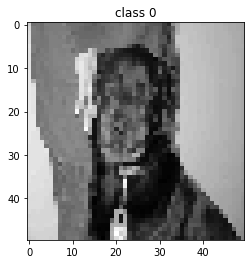

In [134]:
# 50*50 dog for example:
image_plot(images_50_50, Y, 0)

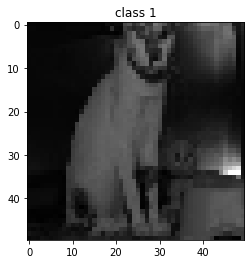

In [93]:
# 50*50 cat for example:
image_plot(images_50_50, Y, 5)

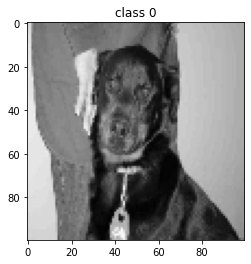

In [94]:
# 100*100 dog for example:
image_plot(images_100_100, Y, 0, 100)

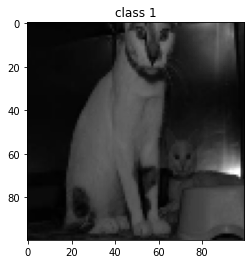

In [95]:
# 100*100 cat for example:
image_plot(images_100_100, Y, 5, 100)

In [100]:
# this function will help me check running time for each algorithem

from datetime import datetime

def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [136]:
X_train, X_test, y_train, y_test = train_test_split(X_50_50, Y, test_size=0.15, random_state = 42)

In [137]:
RFC = RandomForestClassifier()

start_time = timer(None) # timing starts from this point for "start_time" variable
RFC.fit(X_train, y_train)
timer(start_time) # timing ends here for "start_time" variable

y_predict = RFC.predict(X_test)
metrics.accuracy_score(y_predict, y_test)


 Time taken: 0 hours 1 minutes and 31.4 seconds.


0.6376

In [138]:
RFC_kmeans = Pipeline([
    ("kmeans", KMeans(n_clusters=10)), 
    ("RFC", RandomForestClassifier())
])

start_time = timer(None) # timing starts from this point for "start_time" variable
RFC_kmeans.fit(X_train, y_train)
timer(start_time) # timing ends here for "start_time" variable

RFC_kmeans.score(X_test, y_test)


 Time taken: 0 hours 1 minutes and 14.33 seconds.


0.5653333333333334

In [139]:
xgb_kmeans = Pipeline([
    ("kmeans", KMeans(n_clusters=16)), 
    ("xgboost", xgboost.XGBClassifier(use_label_encoder=False))
])

start_time = timer(None) # timing starts from this point for "start_time" variable
xgb_kmeans.fit(X_train, y_train)
timer(start_time) # timing ends here for "start_time" variable

xgb_kmeans.score(X_test, y_test)

[22:16:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

 Time taken: 0 hours 1 minutes and 27.36 seconds.


0.5669333333333333

In [119]:
feature_imp = pd.Series(RFC.feature_importances_,).sort_values(ascending=False)
feature_imp

2475    0.001070
2426    0.000996
2479    0.000932
2481    0.000911
2428    0.000892
          ...   
844     0.000217
53      0.000210
1014    0.000210
301     0.000203
1956    0.000199
Length: 2500, dtype: float64

### PCA Dimensionality Reductioin
- from 2500 features to 290
- 90% of the information remains

In [140]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)

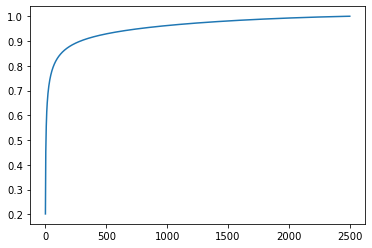

In [141]:
# the elbow is around 0.9 explaind varince, so this is a good point to use.
plt.plot(cumsum)

In [142]:
pca = PCA(n_components= 0.9)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)


# X_sample_reduced = X_reduced[:5000]

In [143]:
print("from 2500 features we have now only " + str(len(X_reduced[0])) + " features which remains 0.9 from the information (variance) of the original data!")

from 2500 features we have now only 290 features which remains 0.9 from the information (variance) of the original data!


In [144]:
RFC_pca = RandomForestClassifier()

start_time = timer(None) # timing starts from this point for "start_time" variable
RFC_pca.fit(X_train_pca, y_train)
timer(start_time) # timing ends here for "start_time" variable

y_predict = RFC.predict(X_test_pca)
metrics.accuracy_score(y_predict, y_test)


 Time taken: 0 hours 0 minutes and 51.54 seconds.


ValueError: Number of features of the model must match the input. Model n_features is 2500 and input n_features is 290 

In [114]:
y_predict = RFC.predict(X_test_pca)
metrics.accuracy_score(y_predict, y_test)


0.6101333333333333

In [ ]:
XGB_pca = xgboost.XGBClassifier()

start_time = timer(None) # timing starts from this point for "start_time" variable
XGB_pca.fit(X_train_pca, y_train, eval_set=[(X_test_pca, y_test)], early_stopping_rounds=10)
timer(start_time) # timing ends here for "start_time" variable

y_predict = XGB_pca.predict(X_test_pca)
metrics.accuracy_score(y_predict, y_test)

In [ ]:
k_range = list(range(1, 31))
k_mean_scores = []
k_std_scores = []

features = list(X_train_scaled.columns.values)
for feature in features:
    knn = KNeighborsClassifier(n_neighbors= min(best_Ks['k_mean'].index))
    scores = cross_val_score(knn, X_train_scaled.drop(columns=feature), y_train, cv=10, scoring='accuracy')
    k_mean_scores.append(scores.mean())

In [ ]:

xgb_params_search = [
    
    {
     'eta': [0.1, 0.3, 0.5, 1],
     'booster':['gbtree','gblinear','dart'],
     'gamma': list(range(0,100, 10)),
     'max_depth': list(range(5,100, 15)),
     'subsample': [0.3, 0.6,1],
        
    }
    
]

random_search_xgb = RandomizedSearchCV(
    XGB_pca,
    param_distributions=xgb_params_search,
    cv=3,
    scoring='accuracy',
    return_train_score=True,
    n_iter=60)
random_search_xgb.fit(X=X_train_pca,y=y_train)

C:\Users\idank\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:22:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:23:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:24:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:25:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [147]:
random_search_xgb.best_estimator_.fit(X=X_train_pca,y=y_train)

C:\Users\idank\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBoostError: [22:21:59] C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:550: Invalid parameter "gamma " contains whitespace.